# Deep Kernel Learning Gaussian Process Regression for a Deiesel Engine Gas Emission Model

## Overview

This notebook provides a brief overview on how to use deep kernel learning (DKL) for regression on a medium scale dataset obtained experimentally by measuring a diesel engine gas emission (carbon-dioxide and nitrogen oxides). For this exercise we will employ PyTorch modules for deep neural networks and GPyTorch for a Gaussian process model.

Firstly, we will load the necessary libraries. 

In [1]:
import math
from math import exp, pi
import numpy
import pandas
import urllib.request
import os.path
from scipy.io import loadmat
from math import floor    
import torch
import gpytorch
from matplotlib import pyplot as plt
from torch import nn, optim
from torch.autograd import Variable

## Load Data

For this notebook, we will be using the Diesel dataset. After randomly shuffling the data, we will simply split the data using the first 90% of the data as training and the last 10% as testing. For visual presentation purposes, we will sort the testing data in ascending order.

In [2]:
# load dataset
dataframe = pandas.read_csv("Input_Output.csv")
dataset = dataframe.values[1:,:]
dataset=dataset.astype(numpy.float)

# Data cleaning
# delete 3rd column (-1's)
dataset = numpy.delete(dataset,(2), axis=1)

dataset = dataset[dataset[:,14] != 0]
dataset = dataset[dataset[:,14] != 0.0]

#dataset = dataset[dataset[:,15] > .1]
#dataset = dataset[dataset[:,15] < 10]

#dataset = dataset[dataset[:,2] != -1]
#dataset = dataset[dataset[:,2] != -1.0]
#remove nan's
dataset[~numpy.any(numpy.isnan(dataset), axis=1)]

import random
idx=[0]*(dataset.shape[0])
for i in range(0,dataset.shape[0]):
    idx[i]=i

random.shuffle(idx)
dataset = dataset[idx,:]

data = torch.Tensor(dataset)

X = data[:, :-2]
X = X - X.min(0)[0]
X = 2 * (X / X.max(0)[0]) - 1
y = data[:, -2]

# Use the first 80% of the data for training, and the last 20% for testing.
train_n = int(floor(0.8*len(X)))
# skip validation
validate_n = int(floor(0.00*len(X)))

train_x = X[:train_n, :].contiguous().cpu()
train_y = y[:train_n].contiguous().cpu()

validate_x = X[train_n:train_n+validate_n].contiguous().cpu()
validate_y = y[train_n:train_n+validate_n].contiguous().cpu()

test_x = X[train_n+validate_n:, :].contiguous().cpu()
test_y = y[train_n+validate_n:].contiguous().cpu()

# sort test data in ascending order
# purely for presentation purposes
def sort_training(test_x, test_y):
    index_test = numpy.argsort(test_y.data.numpy())
    test_x_sort = numpy.empty((0,test_x.data.numpy().shape[1]), int)
    j = 0
    for i in index_test:
        test_x_sort = numpy.vstack((test_x_sort, test_x.data.numpy()[i].reshape(1,-1)))#, axis=0)
        j = j + 1
    test_y_sort = numpy.sort(test_y.data.numpy())
    #test_x = test_x_sort
    #test_y = test_y_sort
    test_x = torch.Tensor(test_x_sort)
    test_y = torch.Tensor(test_y_sort)
    return test_x, test_y

test_x,test_y = sort_training(test_x, test_y)

data_dim = train_x.size(-1)

## Defining the DKL Feature Extractor

We define the neural network feature extractor used to define the deep kernel. In this case, we use a fully connected network with the architecture d -> 1000 -> 500 -> 50 -> 3, and unlike in the original DKL paper, we **do not employ interpolation**. The code below uses standard PyTorch implementations of neural network layers.

__Note 1.__ In case we want to run the model on a GPU, replace *cpu()* with *cuda()*.

__Note 2.__ Unlike in the original DKL paper, we have 3 neurons in the last hidden layer and we do not use KISS.

In [3]:
class LargeFeatureExtractor(torch.nn.Sequential):           
    def __init__(self):                                      
        super(LargeFeatureExtractor, self).__init__()        
        self.add_module('linear1', torch.nn.Linear(data_dim, 1000))
        self.add_module('relu1', torch.nn.ReLU())                  
        self.add_module('linear2', torch.nn.Linear(1000, 500))     
        self.add_module('relu2', torch.nn.ReLU())                  
        self.add_module('linear3', torch.nn.Linear(500, 50))       
        self.add_module('relu3', torch.nn.ReLU())                  
        self.add_module('linear4', torch.nn.Linear(50, 3))         
                                                             
feature_extractor = LargeFeatureExtractor().cpu()

## GP Model

We now define the GP model. This model uses a GridInterpolationKernel (SKI) with an RBF base kernel.

### The forward method

Before calling the mean and covariance modules on the data as in the simple GP regression setting, we first pass the input data x through the neural network feature extractor. 

In order to ensure that the output features of the neural network remain in the grid bounds expected by SKI, we scales the resulting features to be between 0 and 1. Strictly speaking, this is not necessary because we are not using interpolation but it does make a job easier for the GP layer.

In [4]:
class GPRegressionModel(gpytorch.models.ExactGP):
        def __init__(self, train_x, train_y, likelihood):
            super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
            self.mean_module = gpytorch.means.ConstantMean()
            self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=3) 
            + gpytorch.kernels.WhiteNoiseKernel(variances=torch.ones(1)*0.1))
                
            self.feature_extractor = feature_extractor

        def forward(self, x):
            # We're first putting our data through a deep net (feature extractor)
            # We're also scaling the features so that they're nice values
            projected_x = self.feature_extractor(x)
            projected_x = projected_x - projected_x.min(0)[0]
            projected_x = 2 * (projected_x / projected_x.max(0)[0]) - 1
        
            mean_x = self.mean_module(projected_x)
            covar_x = self.covar_module(projected_x)
            return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

likelihood = gpytorch.likelihoods.GaussianLikelihood().cpu()
model = GPRegressionModel(train_x, train_y, likelihood).cpu()

## Training

We train the DKL model learning both the hyperparameters of the Gaussian process and the parameters of the neural network. We use Adam optimizer with fixed learning rate lr=0.01 and 200 iterations.

In [5]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.feature_extractor.parameters()},
    {'params': model.covar_module.parameters()},
    {'params': model.mean_module.parameters()},
    {'params': model.likelihood.parameters()},
], lr=0.01)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iterations = 200
def train():
    for i in range(training_iterations):
        # Zero backprop gradients
        optimizer.zero_grad()
        # Get output from model
        output = model(train_x)
        # Calc loss and backprop derivatives
        loss = -mll(output, train_y)
        loss.backward()
        print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
        optimizer.step()
        

with gpytorch.settings.use_toeplitz(True):
    train()

Iter 1/200 - Loss: 43030.719
Iter 2/200 - Loss: 46704.555
Iter 3/200 - Loss: 27425.672
Iter 4/200 - Loss: 22678.316
Iter 5/200 - Loss: 18858.102
Iter 6/200 - Loss: 17614.445
Iter 7/200 - Loss: 14975.590
Iter 8/200 - Loss: 12447.964
Iter 9/200 - Loss: 10392.365
Iter 10/200 - Loss: 8769.510
Iter 11/200 - Loss: 7728.644
Iter 12/200 - Loss: 7483.655
Iter 13/200 - Loss: 7614.799
Iter 14/200 - Loss: 7595.345
Iter 15/200 - Loss: 7312.912
Iter 16/200 - Loss: 6872.523
Iter 17/200 - Loss: 6418.837
Iter 18/200 - Loss: 6039.530
Iter 19/200 - Loss: 5768.923
Iter 20/200 - Loss: 5605.779
Iter 21/200 - Loss: 5496.412
Iter 22/200 - Loss: 5413.495
Iter 23/200 - Loss: 5341.367
Iter 24/200 - Loss: 5264.078
Iter 25/200 - Loss: 5170.674
Iter 26/200 - Loss: 5054.131
Iter 27/200 - Loss: 4926.478
Iter 28/200 - Loss: 4800.709
Iter 29/200 - Loss: 4688.311
Iter 30/200 - Loss: 4598.923
Iter 31/200 - Loss: 4526.731
Iter 32/200 - Loss: 4457.398
Iter 33/200 - Loss: 4378.287
Iter 34/200 - Loss: 4285.986
Iter 35/200 - 

## Making Predictions

Next we make prediction on the test set and report MAE (Mean Absolute Error) and RMSE (Root Mean Square Error).


In [6]:
model.eval()
likelihood.eval()
with torch.no_grad(), gpytorch.settings.use_toeplitz(False), gpytorch.settings.fast_pred_var():
    preds = model(test_x)

print('Test MAE: {}'.format(torch.mean(torch.abs(preds.mean - test_y))))
print('Test RMSE: {}'.format(torch.sqrt(torch.mean(((preds.mean - test_y))**2))))

Test MAE: 27.615131378173828
Test RMSE: 39.46084213256836


## Plotting Results

Plot the mean and confidence interval for the test set.

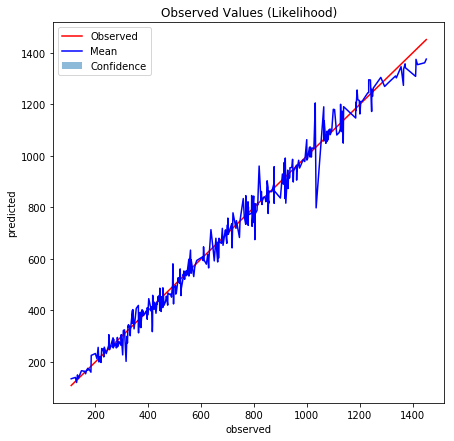

In [7]:
g, observed_ax_y = plt.subplots(1, 1, figsize=(7, 7))
def plot_y(ax, title):
    # Get upper and lower confidence bounds
    lower, upper = preds.confidence_region()
    # Plot observed values as red line
    ax.plot(test_y.data.numpy(), test_y.data.numpy(), 'r')
    # Plot predictive means as blue line
    ax.plot(test_y.data.numpy(), preds.mean.data.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_y.data.numpy(), lower.data.numpy(), upper.data.numpy(), alpha=0.5)
    # Show legend
    ax.legend(['Observed','Mean', 'Confidence'])
    ax.set_title(title)
    ax.set_xlabel('observed')
    ax.set_ylabel('predicted')
# Plot the predictions
plot_y(observed_ax_y, 'Observed Values (Likelihood)')

## Output 2 (NOx)

Using the same method as above, below we treat Output 2.

__Note.__ Because of its logarithmic scale, Output 2 will be $\log_{10}$Output 2.

Iter 1/100 - Loss: 1.039
Iter 2/100 - Loss: 0.932
Iter 3/100 - Loss: 0.925
Iter 4/100 - Loss: 0.901
Iter 5/100 - Loss: 0.895
Iter 6/100 - Loss: 0.892
Iter 7/100 - Loss: 0.883
Iter 8/100 - Loss: 0.880
Iter 9/100 - Loss: 0.873
Iter 10/100 - Loss: 0.873
Iter 11/100 - Loss: 0.867
Iter 12/100 - Loss: 0.864
Iter 13/100 - Loss: 0.861
Iter 14/100 - Loss: 0.857
Iter 15/100 - Loss: 0.854
Iter 16/100 - Loss: 0.849
Iter 17/100 - Loss: 0.845
Iter 18/100 - Loss: 0.843
Iter 19/100 - Loss: 0.837
Iter 20/100 - Loss: 0.832
Iter 21/100 - Loss: 0.830
Iter 22/100 - Loss: 0.824
Iter 23/100 - Loss: 0.822
Iter 24/100 - Loss: 0.817
Iter 25/100 - Loss: 0.813
Iter 26/100 - Loss: 0.809
Iter 27/100 - Loss: 0.805
Iter 28/100 - Loss: 0.803
Iter 29/100 - Loss: 0.800
Iter 30/100 - Loss: 0.792
Iter 31/100 - Loss: 0.788
Iter 32/100 - Loss: 0.783
Iter 33/100 - Loss: 0.781
Iter 34/100 - Loss: 0.776
Iter 35/100 - Loss: 0.772
Iter 36/100 - Loss: 0.765
Iter 37/100 - Loss: 0.761
Iter 38/100 - Loss: 0.756
Iter 39/100 - Loss: 0

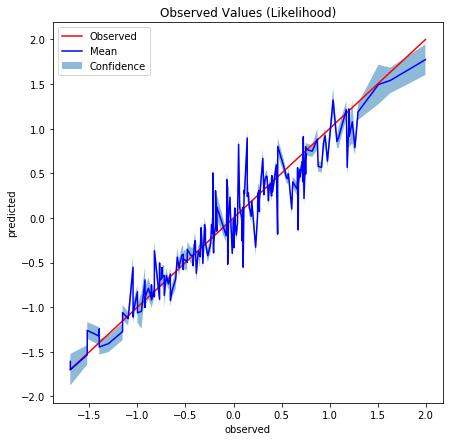

In [11]:
dataset = dataset[dataset[:,15] > 1e-3]
#dataset = dataset[dataset[:,15] < 10]

#dataset = dataset[dataset[:,2] != -1]
#dataset = dataset[dataset[:,2] != -1.0]
#remove nan's
dataset[~numpy.any(numpy.isnan(dataset), axis=1)]

import random
idx=[0]*(dataset.shape[0])
for i in range(0,dataset.shape[0]):
    idx[i]=i

random.shuffle(idx)
dataset = dataset[idx,:]

data = torch.Tensor(dataset)

X = data[:, :-2]
X = X - X.min(0)[0]
X = 2 * (X / X.max(0)[0]) - 1
y = data[:, -1].log10()

# Use the first 80% of the data for training, and the last 20% for testing.
train_n = int(floor(0.9*len(X)))
# skip validation
validate_n = int(floor(0.00*len(X)))

train_x = X[:train_n, :].contiguous().cpu()
train_y = y[:train_n].contiguous().cpu()

validate_x = X[train_n:train_n+validate_n].contiguous().cpu()
validate_y = y[train_n:train_n+validate_n].contiguous().cpu()

test_x = X[train_n+validate_n:, :].contiguous().cpu()
test_y = y[train_n+validate_n:].contiguous().cpu()

# sort test data in ascending order
# purely for presentation purposes
def sort_training(test_x, test_y):
    index_test = numpy.argsort(test_y.data.numpy())
    test_x_sort = numpy.empty((0,test_x.data.numpy().shape[1]), int)
    j = 0
    for i in index_test:
        test_x_sort = numpy.vstack((test_x_sort, test_x.data.numpy()[i].reshape(1,-1)))#, axis=0)
        j = j + 1
    test_y_sort = numpy.sort(test_y.data.numpy())
    #test_x = test_x_sort
    #test_y = test_y_sort
    test_x = torch.Tensor(test_x_sort)
    test_y = torch.Tensor(test_y_sort)
    return test_x, test_y

test_x,test_y = sort_training(test_x, test_y)

data_dim = train_x.size(-1)



class LargeFeatureExtractor(torch.nn.Sequential):           
    def __init__(self):                                      
        super(LargeFeatureExtractor, self).__init__()        
        self.add_module('linear1', torch.nn.Linear(data_dim, 1000))
        self.add_module('relu1', torch.nn.ReLU())                  
        self.add_module('linear2', torch.nn.Linear(1000, 500))     
        self.add_module('relu2', torch.nn.ReLU())                  
        self.add_module('linear3', torch.nn.Linear(500, 50))       
        self.add_module('relu3', torch.nn.ReLU())                  
        self.add_module('linear4', torch.nn.Linear(50, 3))         
                                                             
feature_extractor = LargeFeatureExtractor().cpu()


class GPRegressionModel(gpytorch.models.ExactGP):
        def __init__(self, train_x, train_y, likelihood):
            super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
            self.mean_module = gpytorch.means.ConstantMean()
            self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=3) 
            + gpytorch.kernels.WhiteNoiseKernel(variances=torch.ones(1)*0.1))
                
            self.feature_extractor = feature_extractor

        def forward(self, x):
            # We're first putting our data through a deep net (feature extractor)
            # We're also scaling the features so that they're nice values
            projected_x = self.feature_extractor(x)
            projected_x = projected_x - projected_x.min(0)[0]
            projected_x = 2 * (projected_x / projected_x.max(0)[0]) - 1
        
            mean_x = self.mean_module(projected_x)
            covar_x = self.covar_module(projected_x)
            return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


likelihood = gpytorch.likelihoods.GaussianLikelihood().cpu()
model = GPRegressionModel(train_x, train_y, likelihood).cpu()


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.feature_extractor.parameters()},# 'weight_decay': 0},
    {'params': model.covar_module.parameters()},
    {'params': model.mean_module.parameters()},
    {'params': model.likelihood.parameters()},
], lr=0.01)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iterations = 100
def train():
    for i in range(training_iterations):
        # Zero backprop gradients
        optimizer.zero_grad()
        # Get output from model
        output = model(train_x)
        # Calc loss and backprop derivatives
        loss = -mll(output, train_y)
        loss.backward()
        print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
        optimizer.step()
        

with gpytorch.settings.use_toeplitz(True):
    train()
    

model.eval()
likelihood.eval()
with torch.no_grad(), gpytorch.settings.use_toeplitz(False), gpytorch.settings.fast_pred_var():
    preds = model(test_x)

print('Test MAE: {}'.format(torch.mean(torch.abs(preds.mean - test_y))))
print('Test RMSE: {}'.format(torch.sqrt(torch.mean(((preds.mean - test_y))**2))))


g, observed_ax_y = plt.subplots(1, 1, figsize=(7, 7))
def plot_y(ax, title):
    # Get upper and lower confidence bounds
    lower, upper = preds.confidence_region()
    # Plot observed values as red line
    ax.plot(test_y.data.numpy(), test_y.data.numpy(), 'r')
    # Plot predictive means as blue line
    ax.plot(test_y.data.numpy(), preds.mean.data.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_y.data.numpy(), lower.data.numpy(), upper.data.numpy(), alpha=0.5)
    #ax.set_ylim([-0.01, 10])
    ax.legend(['Observed','Mean', 'Confidence'])
    ax.set_title(title)
    ax.set_xlabel('observed')
    ax.set_ylabel('predicted')
# Plot the predictions
plot_y(observed_ax_y, 'Observed Values (Likelihood)')
